In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
import symlib
import os
from glob import glob
from scipy.stats import linregress


In [ ]:

def density_profile(base_dir, suite_name, snap, n_bins, r_min, r_max, NFW_check=True):
    """
    Measure the density profile of each host halo in a suite at a given snapshot,
    and save the profile as a pandas DataFrame (columns: halo_idx, r_scaled, rho_scaled).
    Return mean_cvir,mean_mvir across all halos if NFW_check=True.
    """

    # read and compute essential parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    mp = params['mp'] / h  # M_sun
    eps = params['eps'] / h  # kpc
    H0 = params["H0"]  # km/s/Mpc
    Om0 = params["Om0"]

    H0_si = params["H0"] * u.km / u.s / u.Mpc
    G_si = G.to(u.Mpc**3 / u.Msun / u.s**2)
    rho_crit = (3 * H0_si**2 / (8 * np.pi * G_si)).to(u.Msun / u.kpc**3).value
    rho_m = Om0 * rho_crit
    print(Om0)

    cvir=[]
    mvir=[]
    
    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue
        center = host['x'][-1]
        r_vir = host['rvir']  # kpc

        if NFW_check:
            cvir_val = host['cvir']
            cvir.append(cvir_val)
            mvir_val = host['m']
            mvir.append(mvir_val)

        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        counts, _ = np.histogram(radi_scaled, bins=bins)
        shell_volumes = (4/3) * np.pi * ((bins[1:] * r_vir)**3 - (bins[:-1] * r_vir)**3)
        mass_per_bin = counts * mp
        rho = mass_per_bin / shell_volumes  # Msun/kpc^3
        rho_scaled = rho / rho_m

        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "rho_scaled": rho_scaled
        })

        out_path = f"{base_dir}/output/{suite_name}/density_profiles"
        os.makedirs(out_path, exist_ok=True)
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

        print(f"[Saved] Halo {halo_idx:03d} density profile saved.")

    mean_cvir = np.mean(cvir)
    mean_mvir = np.mean(mvir)

    print(f'mean concentration:{mean_cvir},mean_mvir:{mean_mvir}')

base_dir = '/Volumes/Atlas/Symphony'
suite_name = 'SymphonyLMC'

density_profile(base_dir, suite_name, snap=235, n_bins=40, r_min=0.001, r_max=1.5)


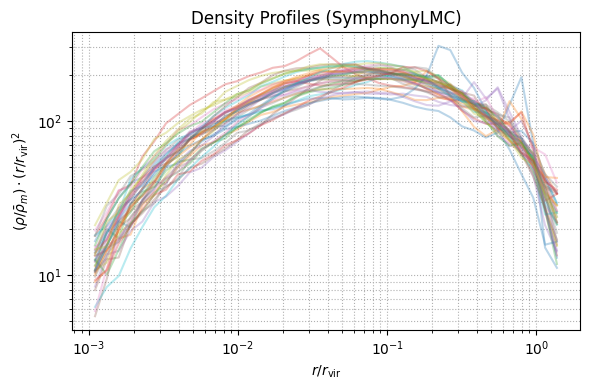

/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_60685/1394362313.py:58: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.loglog(r_scaled, r_scaled**2*nfw_profile(mean_cvir,r_scaled),
/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_60685/1394362313.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.loglog(r_scaled, r_scaled**2*nfw_profile(mean_cvir,r_scaled),


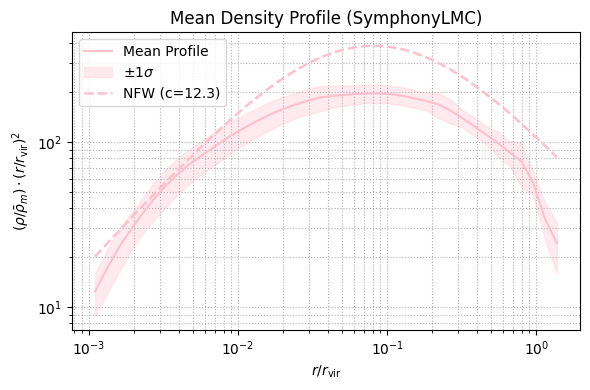

[Done] Plots saved to /Volumes/Atlas/Symphony/output/SymphonyLMC/figures/


In [ ]:
def nfw_profile(c, r_scaled):
    # compute rho_scaled(rho/rho_m)*r_scaled^2 of NFW profile in radius of r_scaled(r/r_vir) 
    f_c = np.log(1 + c) - c / (1 + c)
    x = r_scaled * c
    Om0 = 0.286
    delta_c = (178 * c**3) / (3 * f_c)
    rho_scaled = delta_c / (x * (1 + x)**2) / Om0
    return rho_scaled 

def plot_density(base_dir, suite_name, mean_cvir):
    """
    Plot every halo's scaled density profile (rho * r^2 vs r) and the mean profile of the given suite.
    Optionally overplot an NFW profile using mean_cvir and mean_mvir.
    """

    profile_dir = f"{base_dir}/output/{suite_name}/density_profiles"
    file_list = sorted(glob(f"{profile_dir}/halo_*_profile.csv"))
    
    if not file_list:
        print("[Error] No profile files found.")
        return

    # Read all profiles
    all_profiles = []
    for file in file_list:
        df = pd.read_csv(file)
        df["rho_r2"] = df["rho_scaled"] * df["r_scaled"]**2
        all_profiles.append(df)

    # Extract common bin centers
    r_scaled = all_profiles[0]["r_scaled"].values
    rho_r2_all = np.array([df["rho_r2"].values for df in all_profiles])

    # -------- Plot 1: All halo profiles --------
    plt.figure(figsize=(6, 4))
    for rho_r2 in rho_r2_all:
        plt.loglog(r_scaled, rho_r2, alpha=0.3)
    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel(r"$(\rho/\bar{\rho}_m) \cdot (r/r_{\mathrm{vir}})^2$")
    plt.grid(True, which="both", ls=":")
    plt.title(f"Density Profiles ({suite_name})")
    plt.tight_layout()
    os.makedirs(f"{base_dir}/output/{suite_name}/figures", exist_ok=True)
    plt.savefig(f"{base_dir}/output/{suite_name}/figures/all_halos_profiles.png", dpi=300)
    plt.show()
    plt.close()

    # -------- Plot 2: Mean + 68% range --------
    mean_rho_r2 = np.mean(rho_r2_all, axis=0)
    std_rho_r2 = np.std(rho_r2_all, axis=0)

    plt.figure(figsize=(6, 4))
    plt.loglog(r_scaled, mean_rho_r2, color="pink", label="Mean Profile")
    plt.fill_between(r_scaled, mean_rho_r2 - std_rho_r2, mean_rho_r2 + std_rho_r2,
                     color="pink", alpha=0.3, label=r"$\pm1\sigma$")

    # Overplot NFW
    plt.loglog(r_scaled, r_scaled**2*nfw_profile(mean_cvir,r_scaled),
                'k--', lw=1.8, label=f"NFW (c={mean_cvir:.1f})",linestyle='--', color='pink')

    # ext_df = pd.read_csv('/Volumes/Atlas/Symphony/figure6_LMC.csv')
    # plt.loglog(ext_df["r/R_vir_host"], ext_df["(r/R_vir)^2 rho/rho_m"], color="black", lw=2, label="Extracted LMC Profile")

    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel(r"$(\rho/\bar{\rho}_m) \cdot (r/r_{\mathrm{vir}})^2$")
    plt.grid(True, which="both", ls=":")
    plt.title(f"Mean Density Profile ({suite_name})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{base_dir}/output/{suite_name}/figures/mean_profile.png", dpi=300)
    plt.show()
    plt.close()

    print(f"[Done] Plots saved to {base_dir}/output/{suite_name}/figures/")

plot_density("/Volumes/Atlas/Symphony", "SymphonyLMC", mean_cvir=12.3)

In [37]:
def veloccity_dispersion(base_dir, suite_name, snap, n_bins, r_min, r_max):
    """
    Measure the radial&total veclocity dispersion and anisotropy profiles of each host halo in a suite at a given snapshot,
    and save the profiles as pandas DataFrame (columns: halo_idx, r_scaled, sigmat_scaled, sigmar_scaled, beta).
    note: all measurements are done in host frame.
    """

    # read and compute essential parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    eps = params['eps'] * h  # kpc
    H0 = params["H0"]  # km/s/Mpc

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        # compute virial velocity
        center = host['x'][-1]
        v_host = host['v'][-1] # km/s
        r_vir = host['rvir']  # kpc
        m_vir = host['m'] # M_sun
        m = m_vir * u.Msun
        r = r_vir * u.kpc
        G_kpc = G.to(u.kpc * (u.km/u.s)**2 / u.Msun)
        v_vir = np.sqrt(G_kpc * m / r).to(u.km / u.s).value  # km/s
        
        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        x = p[0]['x'] # kpc
        v = p[0]['v'] # kpc
        dx = x - center
        dv = v - v_host
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        # compute radial and tangential velocities
        r_hat = dx / radi[:, None]
        v_rad = np.sum(dv * r_hat, axis=1)
        v_total = np.linalg.norm(dv,axis=1)
        v_tan = dv - v_rad[:, None] * r_hat
        v_tan_mag = np.linalg.norm(v_tan, axis=1)

        # binned statistics
        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        sigma_rad_scaled = []
        sigma_tan_scaled = []
        sigma_total_scaled = []
        beta_profile = []

        for i in range(n_bins):
            in_bin = (radi_scaled >= bins[i]) & (radi_scaled < bins[i+1])

            sigma_rad = np.std(v_rad[in_bin])
            sigma_rad_scaled.append(sigma_rad / v_vir)

            sigma_x = np.std(dv[in_bin][:, 0])
            sigma_y = np.std(dv[in_bin][:, 1])
            sigma_z = np.std(dv[in_bin][:, 2])
            # sigma_total = np.std(v_total[in_bin])
            sigma_total = np.sqrt(sigma_x**2+sigma_y**2+sigma_z**2)
            sigma_total_scaled.append(sigma_total / v_vir)

            # sigma_tan = np.std(v_tan_mag[in_bin])
            sigma_tan = np.sqrt(sigma_total**2 - sigma_rad**2)
            sigma_tan_scaled.append(sigma_tan / v_vir)

            beta = 1 - sigma_tan**2 / (2 * sigma_rad**2)
            beta_profile.append(beta)

        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "sigma_rad_scaled": sigma_rad_scaled,
            "sigma_tan_scaled": sigma_tan_scaled,
            "sigma_total_scaled": sigma_total_scaled,
            "beta": beta_profile
        })

        out_path = f"{base_dir}/output/{suite_name}/velocity_profiles"
        os.makedirs(out_path, exist_ok=True)
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_vel_profile.csv", index=False)

        print(f"[Saved] Halo {halo_idx:03d} velocity profile saved.")

base_dir = '/Volumes/Atlas/Symphony'
suite_name = 'SymphonyLMC'
veloccity_dispersion(base_dir, suite_name, snap=235, n_bins=40, r_min=0.001, r_max=1.5)

[Saved] Halo 000 velocity profile saved.
[Saved] Halo 001 velocity profile saved.
[Saved] Halo 002 velocity profile saved.
[Saved] Halo 003 velocity profile saved.
[Saved] Halo 004 velocity profile saved.
[Saved] Halo 005 velocity profile saved.
[Saved] Halo 006 velocity profile saved.
[Saved] Halo 007 velocity profile saved.
[Saved] Halo 008 velocity profile saved.
[Saved] Halo 009 velocity profile saved.
[Saved] Halo 010 velocity profile saved.
[Saved] Halo 011 velocity profile saved.
[Saved] Halo 012 velocity profile saved.
[Saved] Halo 013 velocity profile saved.
[Saved] Halo 014 velocity profile saved.
[Saved] Halo 015 velocity profile saved.
[Saved] Halo 016 velocity profile saved.
[Saved] Halo 017 velocity profile saved.
[Saved] Halo 018 velocity profile saved.
[Saved] Halo 019 velocity profile saved.
[Saved] Halo 020 velocity profile saved.
[Saved] Halo 021 velocity profile saved.
[Saved] Halo 022 velocity profile saved.
[Saved] Halo 023 velocity profile saved.
[Saved] Halo 024

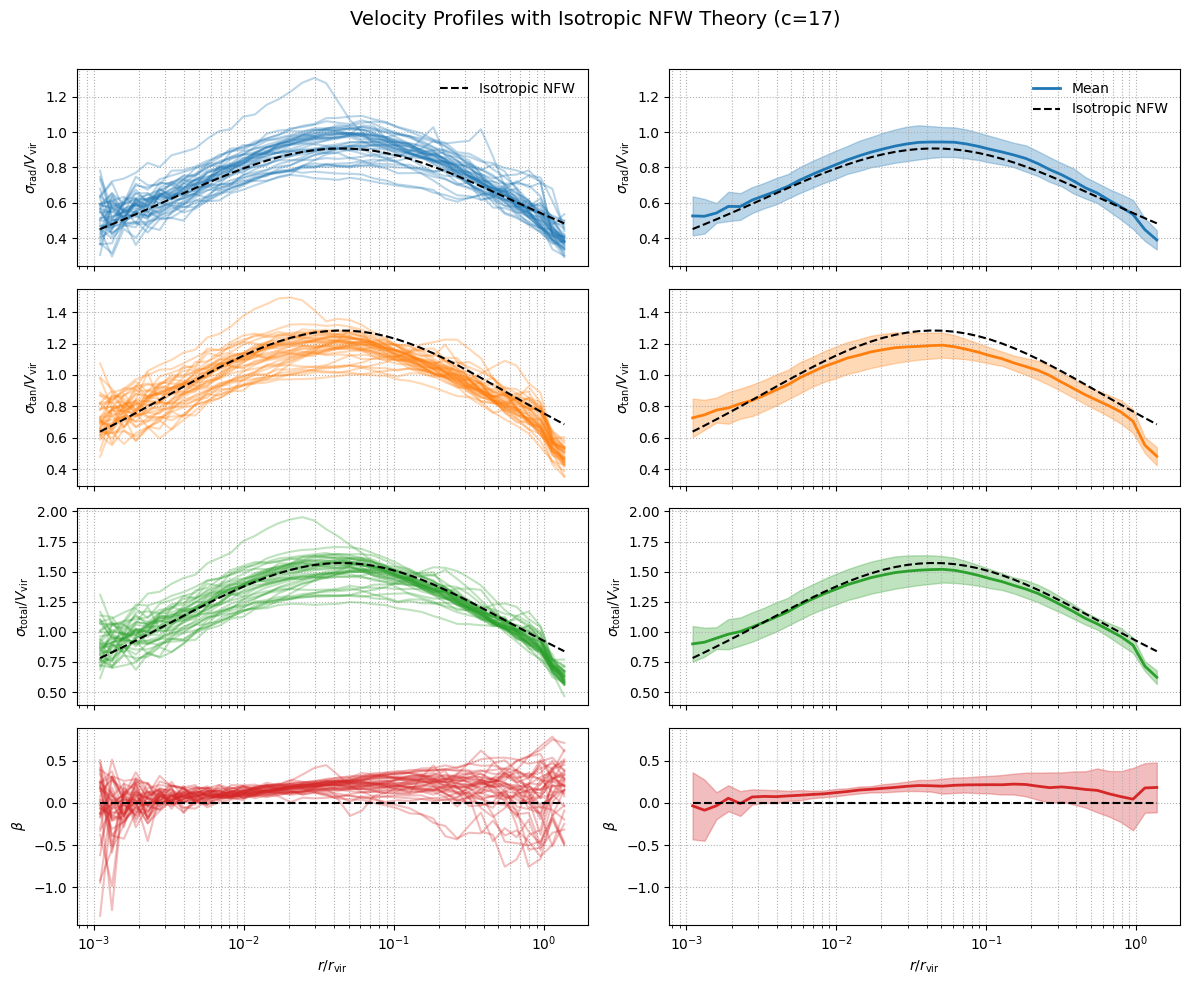

[Saved] Profiles saved with NFW comparison.


In [ ]:

def plot_velocity(base_dir, suite_name, mean_cvir):
    """
    Plot and save the velocity dispersion and anisotropy profiles
    with overplotted isotropic NFW theoretical curves.
    
    Args:
        base_dir: Base directory path
        suite_name: Name of the simulation suite
        concentration: Average NFW concentration parameter (default=10)
    """
    input_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    files = sorted([f for f in os.listdir(input_dir) if f.endswith(".csv")])
    if not files:
        print("[Error] No CSV files found for velocity profiles.")
        return

    # Load all data arrays
    r = pd.read_csv(os.path.join(input_dir, files[0]))["r_scaled"].values
    sigma_rad_all = np.array([pd.read_csv(os.path.join(input_dir, f))["sigma_rad_scaled"].values for f in files])
    sigma_tan_all = np.array([pd.read_csv(os.path.join(input_dir, f))["sigma_tan_scaled"].values for f in files])
    sigma_total_all = np.array([pd.read_csv(os.path.join(input_dir, f))["sigma_total_scaled"].values for f in files])
    beta_all   = np.array([pd.read_csv(os.path.join(input_dir, f))["beta"].values for f in files])

    # =============================================
    # Calculate isotropic NFW theoretical profiles
    # =============================================
    c = mean_cvir
    g_c = 1/(np.log(1 + c) - c / (1 + c))
    
    def integrand(t):
        g_t = (1+c*t)*np.log(1 + c*t) - c*t
        return g_t / (t**3*(1+c*t)**3)
    
    # Pre-calculate theoretical profiles
    sigma_rad_nfw = np.zeros_like(r)
    for i, r_val in enumerate(r):
        if r_val <= 0:  # Skip zero or negative radii
            sigma_rad_nfw[i] = np.nan
            continue
        integral, _ = quad(integrand, r_val, np.inf)
        sigma_r2 = g_c*(1+c*r_val)**2*r_val*integral
        sigma_rad_nfw[i] = np.sqrt(sigma_r2)
    
    sigma_tan_nfw = np.sqrt(2)*sigma_rad_nfw  # Isotropic: σ_rad^2 = 2σ_tan^2
    sigma_total_nfw = np.sqrt(3) * sigma_rad_nfw  # σ_total² = 3σ_rad²
    beta_nfw = np.zeros_like(r)  # Anisotropy β=0 for isotropic case
    
    # ==============
    # Create plots
    # ==============
    fig, axes = plt.subplots(4, 2, figsize=(12, 10), sharex=True)
    titles = [r"$\sigma_{\mathrm{rad}} / V_{\mathrm{vir}}$", 
              r"$\sigma_{\mathrm{tan}} / V_{\mathrm{vir}}$",
              r"$\sigma_{\mathrm{total}} / V_{\mathrm{vir}}$",
              r"$\beta$"]
    data_arrs = [sigma_rad_all, sigma_tan_all, sigma_total_all, beta_all]
    colors = ["C0", "C1", "C2", "C3"]
    nfw_profiles = [sigma_rad_nfw, sigma_tan_nfw, sigma_total_nfw, beta_nfw]

    for i in range(4):
        y_min = np.nanmin(data_arrs[i])
        y_max = np.nanmax(data_arrs[i])
        y_pad = 0.05 * (y_max - y_min)

        # Left panel: all halos + theoretical curve
        for arr in data_arrs[i]:
            axes[i, 0].plot(r, arr, color=colors[i], alpha=0.3)
        axes[i, 0].plot(r, nfw_profiles[i], 'k--', lw=1.5, label='Isotropic NFW')
        axes[i, 0].set_ylabel(titles[i])
        axes[i, 0].set_xscale("log")
        axes[i, 0].set_ylim(y_min - y_pad, y_max + y_pad)
        axes[i, 0].grid(True, which="both", linestyle=":")
        if i == 0:
            axes[i, 0].legend(loc='best', frameon=False)

        # Right panel: mean ± 1σ + theoretical curve
        mean = np.nanmean(data_arrs[i], axis=0)
        std = np.nanstd(data_arrs[i], axis=0)
        axes[i, 1].plot(r, mean, color=colors[i], lw=2, label='Mean')
        axes[i, 1].fill_between(r, mean - std, mean + std, color=colors[i], alpha=0.3)
        axes[i, 1].plot(r, nfw_profiles[i], 'k--', lw=1.5, label='Isotropic NFW')
        axes[i, 1].set_ylabel(titles[i])
        axes[i, 1].set_xscale("log")
        axes[i, 1].set_ylim(y_min - y_pad, y_max + y_pad)
        axes[i, 1].grid(True, which="both", linestyle=":")
        if i == 0:
            axes[i, 1].legend(loc='best', frameon=False)

    axes[3, 0].set_xlabel(r"$r / r_{\mathrm{vir}}$")
    axes[3, 1].set_xlabel(r"$r / r_{\mathrm{vir}}$")
    fig.suptitle(f"Velocity Profiles with Isotropic NFW Theory (c={c})", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.savefig(os.path.join(output_dir, "velocity_profiles_mean_grid_with_NFW.png"))
    plt.show()
    plt.close(fig)

    print("[Saved] Profiles saved with NFW comparison.")

# Run with specified concentration
plot_velocity("/Volumes/Atlas/Symphony", "SymphonyLMC", mean_cvir=17)

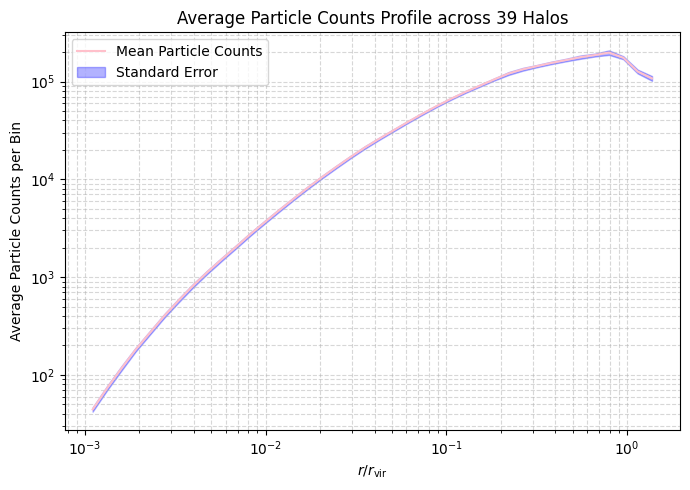

In [61]:
def average_particle_counts_profile(base_dir, suite_name, snap, n_bins=40, r_min=0.001, r_max=1.5, plot=True):
    """
    Compute the average particle counts per radial bin across all host halos in a suite.
    
    Returns:
        bin_centers: array of bin center radii (scaled)
        mean_counts: average particle counts in each bin
        stderr_counts: standard error of particle counts in each bin
    """
    n_halos = symlib.n_hosts(suite_name)
    
    all_counts = []

    # 统一构造bin边界，避免不同halo间bin定义误差
    bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}, skipped.")
            continue
        
        center = host['x'][-1]
        r_vir = host['rvir']

        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}, skipped.")
            continue
        
        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir
        
        counts, _ = np.histogram(radi_scaled, bins=bins)
        all_counts.append(counts)

    if len(all_counts) == 0:
        raise RuntimeError("No halo data available for particle count statistics.")
    
    all_counts = np.array(all_counts)
    mean_counts = np.mean(all_counts, axis=0)
    stderr_counts = np.std(all_counts, axis=0) / np.sqrt(all_counts.shape[0])
    
    if plot:
        plt.figure(figsize=(7,5))
        plt.plot(bin_centers, mean_counts, label='Mean Particle Counts', color='pink')
        plt.fill_between(bin_centers, mean_counts - stderr_counts, mean_counts + stderr_counts,
                         color='blue', alpha=0.3, label='Standard Error')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r"$r / r_{\mathrm{vir}}$")
        plt.ylabel("Average Particle Counts per Bin")
        plt.title(f"Average Particle Counts Profile across {len(all_counts)} Halos")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    return bin_centers, mean_counts, stderr_counts

base_dir = '/Volumes/Atlas/Symphony'
suite_name = 'SymphonyLMC'
snap = 235

r_centers, mean_counts, stderr_counts = average_particle_counts_profile(base_dir, suite_name, snap)